In [1]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta
from itertools import chain

from datetime import date


sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [3]:
cwfis_perims = gpd.read_file("/projects/old_shared/fire_weather_vis/Lightning_analysis/CWFIS/perim_progression/progression.shp")

In [4]:
#cwfis_perims = cwfis_perims.set_crs("EPSG:4326")


In [5]:
cwfis_perims[1:4].explore()

In [6]:
cwfis_perims.columns

Index(['CLUSTERID', 'DATE', 'AREA', 'C_AREA', 'FWI', 'CONSIS_ID', 'geometry'], dtype='object')

In [7]:
import seaborn as sn

In [8]:
cwfis_perims.DATE

0        20230419.0
1        20230420.0
2        20230428.0
3        20230428.0
4        20230803.0
            ...    
12535    20231004.0
12536    20231009.0
12537    20231009.0
12538    20231009.0
12539    20231009.0
Name: DATE, Length: 12540, dtype: float64

[Text(0.5, 23.52222222222222, ''), Text(50.722222222222214, 0.5, '')]

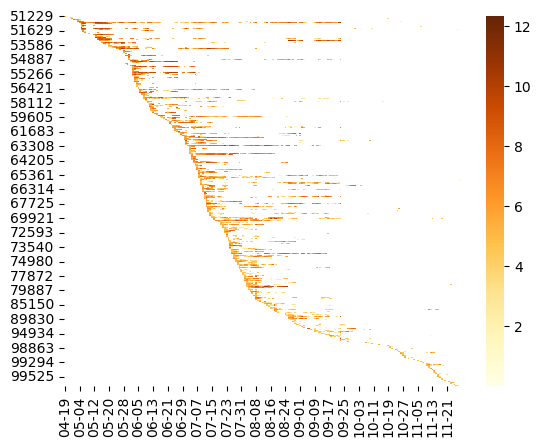

In [9]:
cwfis_perims["log_area"] = np.log(cwfis_perims.AREA)
cwfis_perims["better_format_date"] = pd.to_datetime(cwfis_perims.DATE.astype("str"), format="%Y%m%d.0")
#cwfis_perims.DATE = cwfis_perims.DATE.astype("datetime64[ns]")
cwfis_perims["better_format_date2"] = cwfis_perims["better_format_date"].astype("datetime64[ns]").dt.strftime("%m-%d")

heat = cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2"]].pivot(index="CONSIS_ID", columns="better_format_date2", values="log_area")
ax = sn.heatmap(heat, cmap = "YlOrBr")
ax.set(xlabel="", ylabel="")

[Text(0.5, 23.52222222222222, ''), Text(50.722222222222214, 0.5, '')]

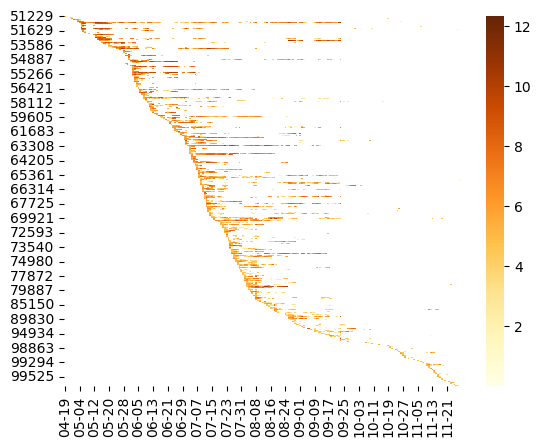

In [10]:
### Sort by lattitude 

cwfis_perims["x_component"] = cwfis_perims.geometry.centroid.x
cwfis_perims["y_component"] = cwfis_perims.geometry.centroid.y

cwfis_perims = cwfis_perims.sort_values(by = "y_component")



cwfis_perims["log_area"] = np.log(cwfis_perims.AREA)
cwfis_perims["better_format_date"] = pd.to_datetime(cwfis_perims.DATE.astype("str"), format="%Y%m%d.0")
#cwfis_perims.DATE = cwfis_perims.DATE.astype("datetime64[ns]")
cwfis_perims["better_format_date2"] = cwfis_perims["better_format_date"].astype("datetime64[ns]").dt.strftime("%m-%d")

heat = cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2", "y_component"]].pivot(index="CONSIS_ID", columns="better_format_date2", values="log_area")
ax = sn.heatmap(heat, cmap = "YlOrBr")
ax.set(xlabel="", ylabel="")

In [11]:
cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2", "y_component"]]

,CONSIS_ID,log_area,better_format_date2,y_component
4179,56414,8.034955,06-07,-1.718501e+05
1351,56414,6.769635,06-08,-1.718199e+05
3893,56414,5.032990,06-09,-1.688131e+05
2207,56414,7.063519,06-06,-1.680826e+05
1716,56927,4.209188,06-10,-1.674590e+05
...,...,...,...,...
7933,75548,4.571440,07-30,2.681887e+06
4383,75548,5.105485,07-29,2.682487e+06
3840,76097,3.256696,08-01,2.690793e+06
10086,76097,3.777458,07-31,2.691180e+06


In [12]:
#heat.sort_values()

In [13]:
### Now with feds perimeters

path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/20_days_fire_stats_only_718270-99999_minT20230301_maxT20230830_BOREAL_NRT_3571_DPSstation20231120.csv" ## looking for lightning 20 days before start
fires = fv.prep_fire_files(path)
#fires = fv.remerge_largefire(fires) ### CAUSES ISSUES WITH AREA DIFFERENCING. 

In [14]:
fires

,fireID,t,geometry,Unnamed: 0,InterCloud,lat,lon,current_mag,error_elps,num_station,...,BUI,ISI,FWI,OBSMINUTEDIFF_TEMP,OBSMINUTEDIFF_RH,OBSMINUTEDIFF_WDSPD,ISPRECREPORTED,OBSMINUTEDIFF_SNOW,OBSMINUTEDIFF_VIS,pre_fire
0,9203,2023-06-01 21:50:48.378,None,0,0.0,49.050685,-75.065585,7634.0,20.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,9203,2023-06-01 21:50:48.378,None,1,0.0,49.050685,-75.065585,7634.0,20.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,9203,2023-06-01 21:50:48.378,None,0,0.0,49.050685,-75.065585,7634.0,20.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,9203,2023-06-01 21:50:48.378,None,1,0.0,49.050685,-75.065585,7634.0,20.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,9203,2023-06-01 22:38:58.228,None,2,0.0,49.065694,-75.045426,8725.0,16.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160107,9268,2023-07-03 07:00:00,None,1152,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.875352,15.279587,0.0,0.0,0.0,1.0,0.0,0.0,False
160108,9268,2023-07-03 08:00:00,None,1153,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.336880,17.095431,0.0,0.0,0.0,1.0,0.0,0.0,False
160109,9268,2023-07-03 09:00:00,None,1154,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.282460,23.834460,0.0,0.0,0.0,1.0,0.0,0.0,False
160110,9268,2023-07-03 10:00:00,None,1155,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.814687,22.323336,0.0,0.0,0.0,1.0,0.0,0.0,False


In [15]:
fires = fires[~fires.geometry.isna()]

In [16]:
fires = fires.sort_values(by = ["fireID", "t"])
fires.farea = fires.farea.astype("int64")
fires["farea_diff"] = fires.groupby("fireID").farea.diff()

In [17]:
#fires[fires.fireID == '12596']

In [18]:
# weird_diff_ids = fires[fires.farea_diff< 0][["fireID", "t", "farea", "farea_diff"]].fireID.unique()

# fires[fires.fireID.isin(weird_diff_ids)][["fireID", "t", "farea", "farea_diff"]]
fires.columns


Index(['fireID', 't', 'geometry', 'Unnamed: 0', 'InterCloud', 'lat', 'lon',
       'current_mag', 'error_elps', 'num_station', 'num_candidates',
       'num_strikes', 'num_strikes_10_days', 'no_strikes_in_time',
       'viirs_pix_count', 'n_pixels', 'n_newpixels', 'farea', 'fperim',
       'flinelen', 'duration', 'pixden', 'meanFRP', 'csv_geometry',
       'lon_centroid', 'lat_centroid', 'TEMP_C', 'RH_PERC', 'VPD_HPA',
       'WDSPD_KPH', 'PREC_MM', 'SNOWD_M', 'VIS_KM', 'FFMC', 'DMC', 'DC', 'BUI',
       'ISI', 'FWI', 'OBSMINUTEDIFF_TEMP', 'OBSMINUTEDIFF_RH',
       'OBSMINUTEDIFF_WDSPD', 'ISPRECREPORTED', 'OBSMINUTEDIFF_SNOW',
       'OBSMINUTEDIFF_VIS', 'pre_fire', 'farea_diff'],
      dtype='object')

In [19]:
fires.t

10818        2023-06-12 12:00:00
10816        2023-06-13 00:00:00
10817        2023-06-13 12:00:00
10819        2023-06-14 00:00:00
10832        2023-06-14 12:00:00
                  ...           
99171    2023-06-18 12:00:00.000
99172    2023-06-19 00:00:00.000
99186    2023-06-19 12:00:00.000
99169    2023-06-20 00:00:00.000
99187    2023-06-20 12:00:00.000
Name: t, Length: 6353, dtype: object

In [20]:
#fires["log_area"] = np.log(fires.farea)

fires.t = pd.to_datetime(fires.t, format='ISO8601')
#fires.better_format_date.astype("datetime64[ns]")
fires["pretty_date_format"] = fires.t.astype("datetime64[ns]").dt.strftime("%m-%d %p")
#fires["better_format_date"] = pd.to_datetime(fires.t.astype("str"), format="%Y%m%d.0")
#cwfis_perims.DATE = cwfis_perims.DATE.astype("datetime64[ns]")
#cwfis_perims["better_format_date2"] = cwfis_perims["better_format_date"].astype("datetime64[ns]").dt.strftime("%m-%d")
no_dupes = fires[["fireID", "pretty_date_format", "farea_diff", "lat_centroid", "t"]]
#no_dupes[no_dupes.fireID == '9203']

In [21]:
#no_dupes[no_dupes.farea_diff < 0]

In [22]:
# heat = no_dupes.reset_index().pivot_table(index =no_dupes.index ,  columns=["fireID","t"], values="log_area")
# ax = sn.heatmap(heat, cmap = "YlOrBr")
# ax.set(xlabel="", ylabel="")

In [23]:
# no_dupes.t = no_dupes.t.astype('datetime64[ns]')
# no_dupes.fireID = no_dupes.fireID.astype("int64")

no_dupes = no_dupes.dropna()
no_dupes = no_dupes.drop_duplicates(subset = ["fireID", "t"])
no_dupes["log_difference"] = np.log(no_dupes.farea_diff)

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
# Get the mean centroid point per fireID

lats = no_dupes.groupby("fireID").lat_centroid.mean().reset_index()
lats

,fireID,lat_centroid
0,10054,50.606563
1,10140,49.389034
2,10373,50.843340
3,10406,53.423293
4,10435,49.052054
...,...,...
154,9612,50.712364
155,9791,50.783079
156,9837,51.685943
157,9843,53.989744


In [25]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

no_dupes = no_dupes[['fireID', 'pretty_date_format', 'farea_diff', 'log_difference', 't']].merge(lats, on = ["fireID"])

In [26]:
no_dupes.farea_diff = no_dupes.farea_diff

In [27]:
#heat = no_dupes.pivot(index =["fireID", "lat_centroid"],  columns=["pretty_date_format"], values="farea_diff")
heat = no_dupes.pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values="farea_diff")

In [28]:
heat = heat.sort_values(by = "lat_centroid", ascending= False)
heat.index = heat.index.astype("float64")

heat.index = heat.index.values.round(2)



In [29]:
#cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2", "y_component"]][cwfis_perims.CONSIS_ID == 56414]

In [30]:
#no_dupes = no_dupes.set_index(['fireID', 'pretty_date_format', 'farea_diff'], append=True)

In [31]:
# heat = no_dupes[2485:2500].pivot(index = "fireID", columns=["pretty_date_format"], values="farea_diff")
# ax = sn.heatmap(heat, cmap = "YlOrBr")
# ax.set(xlabel="", ylabel="")

In [32]:
s3.ls("s3://veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/")

['veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/._FireZoneMap.nZones.2.png',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/._FireZoneMap.nZones.3.png',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/._SNPPVIIRS.Counts.nZones.3.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/FireZoneMap.nZones.2.png',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/FireZoneMap.nZones.3.png',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/SNPPVIIRS.Counts.nZones.2.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/SNPPVIIRS.Counts.nZones.3.csv']

In [33]:
s3.ls("s3://veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing")

['veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/1.DC.NorthernQuebec.raw.chiclet.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/1.FWI.NorthernQuebec.raw.chiclet.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/2.DC.CentralQuebec.raw.chiclet.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/2.DC.SouthernQuebec.raw.chiclet.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/2.FWI.CentralQuebec.raw.chiclet.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/2.FWI.SouthernQuebec.raw.chiclet.csv',
 'veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chi

In [34]:
FWI_data_south = pd.read_csv("s3://veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/2.FWI.SouthernQuebec.raw.chiclet.csv")

FWI_data_north = pd.read_csv("s3://veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing/1.FWI.NorthernQuebec.raw.chiclet.csv")

In [35]:
fwis = FWI_data_south[["INITDATE", "0"]]
fwis = fwis.rename(columns={"0":"GEOS_5"})

fwin = FWI_data_north[["INITDATE", "0"]]
fwin = fwin.rename(columns={"0":"GEOS_5"})

Text(0, 0.5, 'FWI')

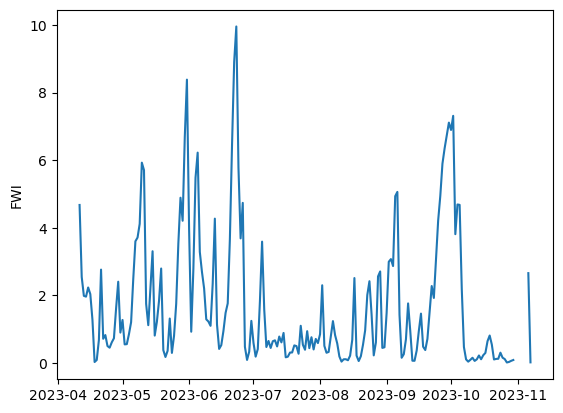

In [36]:
plt.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
plt.ylabel("FWI")

Text(0, 0.5, 'FWI')

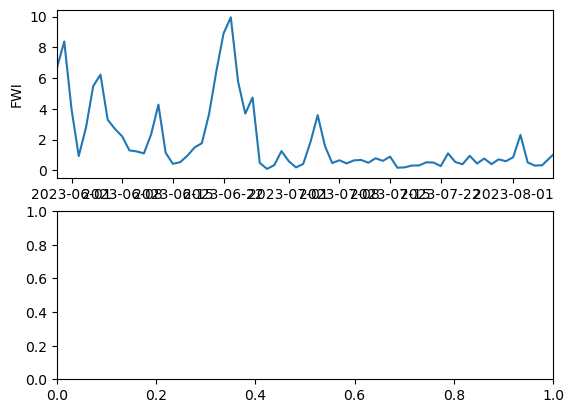

In [37]:
fig, (ax, ax2) = plt.subplots(2)
ax.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
ax.set_ylabel("FWI")

In [38]:
no_dupes.columns

Index(['fireID', 'pretty_date_format', 'farea_diff', 'log_difference', 't',
       'lat_centroid'],
      dtype='object')

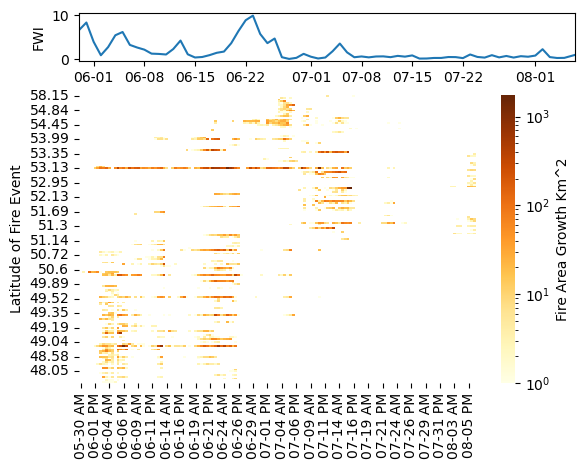

In [39]:
import matplotlib.dates as mdates

fig, (ax, ax2) = plt.subplots(2, gridspec_kw={'height_ratios': [1, 6]})
#fig.suptitle('Aligning x-axis using sharex')
ax2 = sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, fmt='.1f')#, 
               #yticklabels=heat.index.values.round(0))
ax2.set(xlabel="", ylabel="Latitude of Fire Event")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
ax.set_ylabel("FWI")
plt.savefig('Regional_fire_growth_FWI.png')

In [40]:
# dates = heat.columns.values.astype('datetime64[ns]')
# dates.values.astype('datetime64[ns]')

dates = no_dupes['t'].astype('datetime64[ns]')
dates = dates.drop_duplicates()
print(len(dates.dt.strftime('%-m-%-d')))
print(len(heat.columns))

138
138


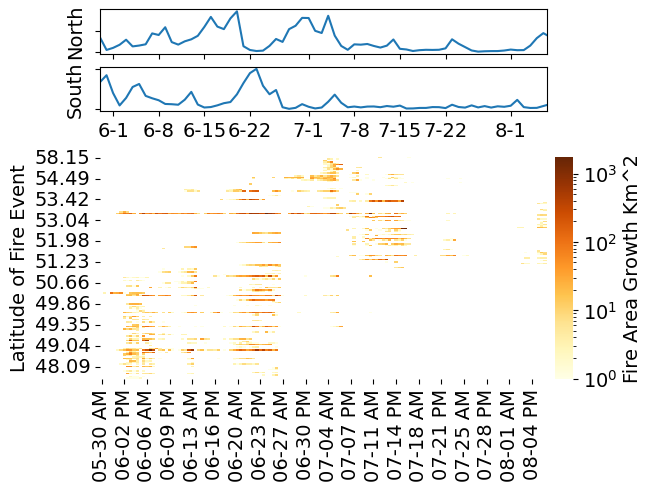

In [41]:
import matplotlib.dates as mdates
import matplotlib as mpl
# fig, ax  = plt.subplots(2, 2, sharex='col', gridspec_kw={'width_ratios':[100,5]})
# ax[0,1].remove()  # remove unused upper right axes
# ax[0,0].plot(x+0.5,L_1,'-', marker='o',color='tab:orange')
# sn.heatmap(M_1, cmap=cmap, vmax=np.max(M_1), center=np.max(M_1)/2., square=False, ax=ax[1,0], cbar_ax=ax[1,1])

#plt.style.use('dark_background')
with mpl.rc_context({'font.size': 14}):
    fig, ([ax, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3,2, gridspec_kw={'width_ratios':[100,4], 'height_ratios': [1,1, 5]}, constrained_layout=True)
    #fig.suptitle('Aligning x-axis using sharex')

    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    ax.plot(fwin.INITDATE.astype("datetime64[ns]"),fwin.GEOS_5)
    ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
    ax.set_ylabel("North")
    ax.set_xticklabels("")
    ax.set_yticklabels("")


    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%-d'))
    ax3.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
    ax3.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
    ax3.set_ylabel("South")
    ax3.set_yticklabels("")



    #ax3 = 
    sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    ax5.set(xlabel="", ylabel="Latitude of Fire Event")
    ax2.remove()
    ax4.remove()

    #plt.gcf().subplots_adjust(bottom=0.15)
    #plt.tight_layout()
    #plt.show()
    plt.savefig('Regional_fire_growth_FWI.png', dpi = 900, transparent = False)

In [42]:
#plt.savefig?

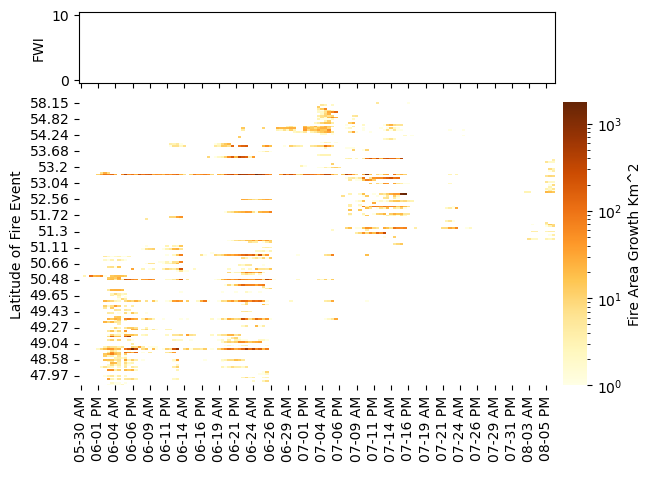

In [43]:


fig, ax  = plt.subplots(2, 2, sharex='col', gridspec_kw={'width_ratios':[100,5], 'height_ratios': [1, 4]}, constrained_layout=True)
  # remove unused upper right axes

ax[0,0].plot(fwis.INITDATE.astype("datetime64[ns]"), fwis.GEOS_5)
ax[0,0].set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
ax[0,0].set_ylabel("FWI")
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))


sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, fmt='.1f', square=False, ax=ax[1,0], cbar_ax=ax[1,1])
ax[1,0].set_ylabel("Latitude of Fire Event")
ax[1,0].set_xlabel(" ")

ax[0,1].remove()



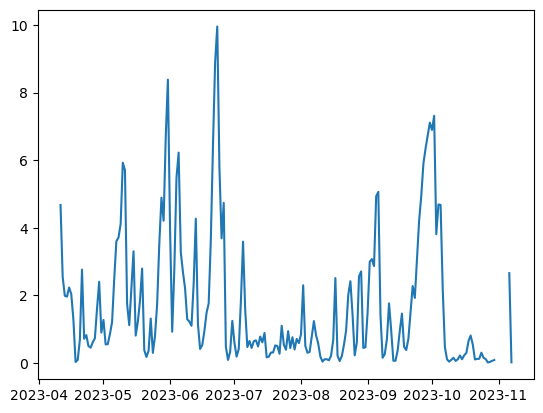

In [44]:
plt.plot(fwis.INITDATE.astype("datetime64[ns]"), fwis.GEOS_5)

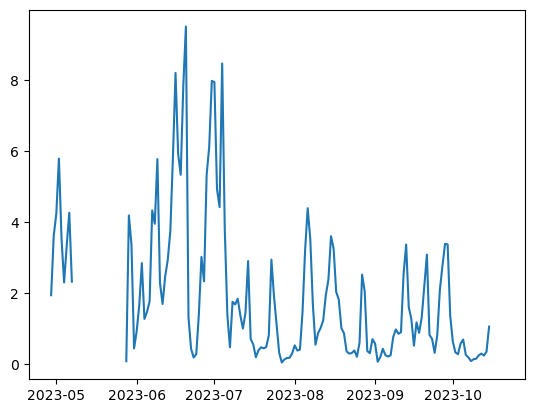

In [45]:
plt.plot(fwin.INITDATE.astype("datetime64[ns]"), fwin.GEOS_5)

In [172]:
### Tess trying to make equivilant plot but using FWI instead of fire area

## SEEMS LIKE THE COLORS SCALE A LITTLE BIT DIFFERENLTLY, MONSTER FIRE SCALED DOWN? NOT THERE???? 

#path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Quebec_only_GRIDDED_20_days_BOREAL_NRT_3571_DPSgridded20240122.csv" ## looking for lightning 20 days before start
path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Final_dataset_as_of_20240209.csv"

fire2 = fv.prep_fire_files(path)
fire_tmp = fire2

In [86]:
fire_tmp.fireID.unique()

array(['9791', '16528', '8570', '10729', '12138', '8629', '9188', '8562',
       '10792', '12202', '13039', '10806', '10147', '8612', '12652',
       '16441', '11265', '12636', '8643', '8756', '9843', '12197',
       '13042', '9187', '12329', '8572', '8723', '13149', '16456', '8621',
       '12690', '12199', '10054', '8904', '10435', '12688', '12145',
       '16963', '12146', '10546', '16107', '8880', '8534', '10286',
       '12207', '10373', '16062', '16038', '8502', '12603', '10406',
       '9203', '12756', '12118', '8732', '10718', '13135', '8872',
       '11603', '16141', '11208', '16520', '11355', '16457', '10538',
       '12153', '16109', '8881', '9200', '10069', '16113', '16519',
       '11302', '11141', '11713', '8671', '8624', '16047', '8649', '8630',
       '13021', '12212', '12147', '10972', '12640', '10481', '8563',
       '12276', '8631', '10713', '10511', '10140', '8642', '10750',
       '8474', '8920', '11221', '8639', '12151', '12159', '12602', '9844',
       '13124', '

2023-01-01 12:00:00
2024-01-08 12:00:00


/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


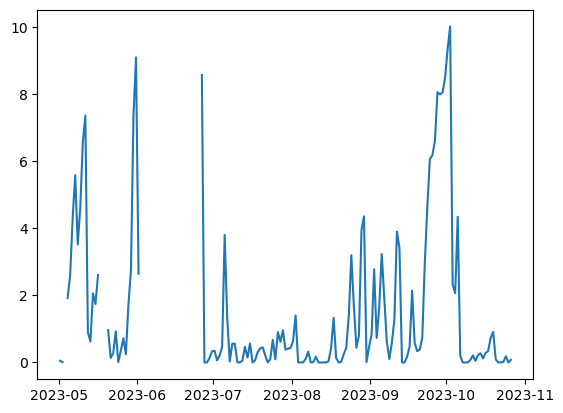

In [173]:
fire_id = fire_tmp[fire_tmp.fireID == '8553']
fire_id.t = fire_id.t.astype('datetime64[ns]')
fire_id = fire_id.sort_values(by = ["fireID", "t"])
plt.plot(fire_id.t, fire_id.FWI)
print(min(fire_id.t))
print(max(fire_id.t))

In [47]:
fire2 = fire2[~fire2.geometry.isna()]

fire2 = fire2.sort_values(by = ["fireID", "t"])
fire2.farea = fire2.farea.astype("int64")
fire2["farea_diff"] = fire2.groupby("fireID").farea.diff()

fire2.t[~fire2.t.str.contains(".000")] = fire2.t[~fire2.t.str.contains(".000")] + ".000"

/tmp/ipykernel_346/4063553203.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire2.t[~fire2.t.str.contains(".000")] = fire2.t[~fire2.t.str.contains(".000")] + ".000"


In [48]:
fire2["pretty_date_format"] = fire2.t.astype("datetime64[ns]").dt.strftime("%m-%d %p")
no_dupes = fire2[["fireID", "pretty_date_format", "farea_diff", "lat_centroid", "t"]]
no_dupes = no_dupes.dropna()
no_dupes = no_dupes.drop_duplicates(subset = ["fireID", "t"])
no_dupes["log_difference"] = np.log(no_dupes.farea_diff)
lats = no_dupes.groupby("fireID").lat_centroid.mean().reset_index()


from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

no_dupes = no_dupes[['fireID', 'pretty_date_format', 'farea_diff', 'log_difference', 't']].merge(lats, on = ["fireID"])

#heat = no_dupes.pivot(index =["fireID", "lat_centroid"],  columns=["pretty_date_format"], values="farea_diff")
heat = no_dupes.pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values="farea_diff")

heat = heat.sort_values(by = "lat_centroid", ascending= False)
heat.index = heat.index.astype("float64")

heat.index = heat.index.values.round(2)

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [72]:
#fire3

In [56]:
# #path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/againQuebec_only_GRIDDED_20_days_BOREAL_NRT_3571_DPSgridded20240122.csv" 
# path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Final_dataset_as_of_20240209.csv"
# fire3 = fv.prep_fire_files(path)
# fire3 = fire3[~fire3.geometry.isna()]

# fire3 = fire3.sort_values(by = ["fireID", "t"])
# fire3.farea = fire3.farea.astype("int64")
# fire3["farea_diff"] = fire3.groupby("fireID").farea.diff()

# fire3.t[~fire3.t.str.contains(".000")] = fire3.t[~fire3.t.str.contains(".000")] + ".000"

/tmp/ipykernel_3150/1125021390.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire3.t[~fire3.t.str.contains(".000")] = fire3.t[~fire3.t.str.contains(".000")] + ".000"


In [73]:
# fire3["pretty_date_format"] = fire3.t.astype("datetime64[ns]").dt.strftime("%m-%d %p")
# no_dupes = fire3[["fireID", "pretty_date_format", "farea_diff", "lat_centroid", "t"]]
# no_dupes = no_dupes.dropna()
# no_dupes = no_dupes.drop_duplicates(subset = ["fireID", "t"])
# no_dupes["log_difference"] = np.log(no_dupes.farea_diff)
# lats = no_dupes.groupby("fireID").lat_centroid.mean().reset_index()


# from matplotlib.colors import LogNorm, Normalize
# from matplotlib.ticker import MaxNLocator

# no_dupes = no_dupes[['fireID', 'pretty_date_format', 'farea_diff', 'log_difference', 't']].merge(lats, on = ["fireID"])

# #heat = no_dupes.pivot(index =["fireID", "lat_centroid"],  columns=["pretty_date_format"], values="farea_diff")
# heat = no_dupes.pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values="farea_diff")

# heat = heat.sort_values(by = "lat_centroid", ascending= False)
# heat.index = heat.index.astype("float64")

# heat.index = heat.index.values.round(2)

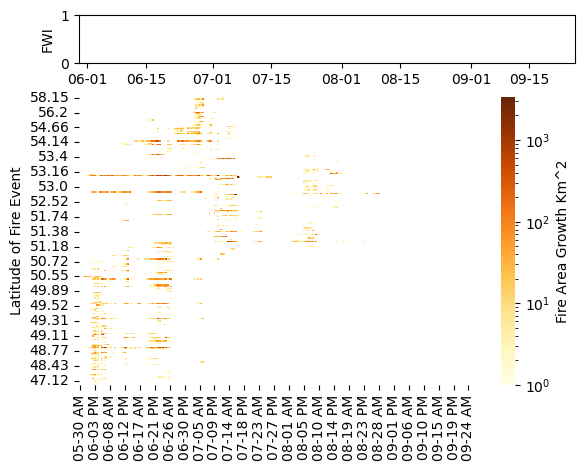

In [49]:
import matplotlib.dates as mdates
import seaborn as sn

fig, (ax, ax2) = plt.subplots(2, gridspec_kw={'height_ratios': [1, 6]})
#fig.suptitle('Aligning x-axis using sharex')
ax2 = sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, fmt='.1f')#, 
               #yticklabels=heat.index.values.round(0))
ax2.set(xlabel="", ylabel="Latitude of Fire Event")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
ax.set_ylabel("FWI")
plt.savefig('Regional_fire_growth_FWI.png')

2023-01-01 12:00:00
2024-01-08 12:00:00


/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


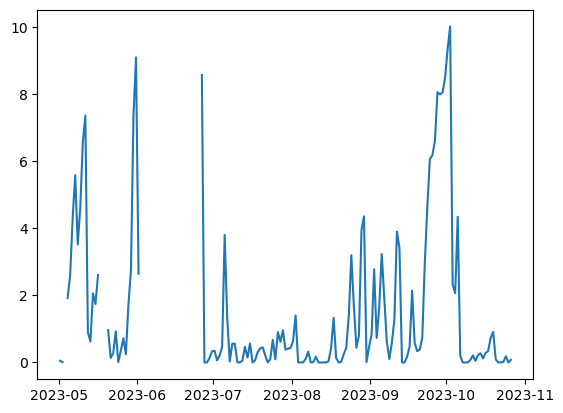

In [174]:
# ## Try with FWI:
#fire_tmp[fire_tmp.t == "2023-11-27 12:00:00"]
#fire_tmp[fire_tmp.t.str.contains("12:00:00") & (~fire_tmp.t.str.contains(".000"))]

## Lightning timestamps at higher resolution, trying to drop just them

fire_tmp = fire_tmp[fire_tmp.InterCloud.isnull()]

# fire_id = fire_tmp[fire_tmp.fireID == '8553']
# fire_id.t = fire_id.t.astype('datetime64[ns]')
# fire_id = fire_id.sort_values(by = ["fireID", "t"])
# plt.plot(fire_id.t, fire_id.FWI)
# print(min(fire_id.t))
# print(max(fire_id.t))

In [176]:
# mask = fire_tmp.t.str.contains("12:00:00") & (~fire_tmp.t.str.contains(".000"))
# # mask = ~fire_tmp.t.str.contains(".")
# fire_tmp.loc[mask, "t"] = fire_tmp.loc[mask, "t"] + ".000"
# #fire_tmp.loc[mask, "t"]

mask = fire_tmp.t.str.contains("0.0")
# mask = ~fire_tmp.t.str.contains(".")
fire_tmp.loc[~mask, "t"] = fire_tmp.loc[~mask, "t"] + ".000"
#fire_tmp.loc[mask, "t"]
fire_tmp[~fire_tmp.t.str.contains("0.0")].t.unique()

# fire_id = fire_tmp[fire_tmp.fireID == '8553']
# fire_id.t = fire_id.t.astype('datetime64[ns]')
# fire_id = fire_id.sort_values(by = ["fireID", "t"])
# plt.plot(fire_id.t, fire_id.FWI)
# print(min(fire_id.t))
# print(max(fire_id.t))

array([], dtype=object)

In [178]:
mask = fire_tmp.t.str.contains("0.000")
fire_tmp.loc[~mask, "t"] = fire_tmp.loc[~mask, "t"] + ".000"
fire_tmp[~fire_tmp.t.str.contains("0.000")].t.unique()

# fire_id = fire_tmp[fire_tmp.fireID == '8553']
# fire_id.t = fire_id.t.astype('datetime64[ns]')
# fire_id = fire_id.sort_values(by = ["fireID", "t"])
# plt.plot(fire_id.t, fire_id.FWI)
# print(min(fire_id.t))
# print(max(fire_id.t))

array([], dtype=object)

In [93]:
fire_tmp[fire_tmp.t.str.contains("12:00:00")].t.unique()
fire_tmp[~fire_tmp.t.str.contains("0.000")].t.unique()

array([], dtype=object)

In [179]:
#fire_tmp["max_t"] = fire_tmp.groupby('fireID').t.max()


def get_centroid(df):
    df_tmp = df[~df.geometry.isnull()]
    max_t = df_tmp.t.max()
    lat = df_tmp[df_tmp.t == max_t].centroid.y
    lon = df_tmp[df_tmp.t == max_t].centroid.x
    print(lat.iloc[0])
    df["lat_centroid"] = lat.iloc[0]
    df["lon_centroid"] = lon.iloc[0]
    return(df)
fire_id = fire_id.to_crs("4326")
fire_id[['fireID', 't', 'lat_centroid']]
foo = get_centroid(fire_id)
foo[['fireID', 't', 'lat_centroid']]

49.47379066554581


/tmp/ipykernel_346/1203727154.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df_tmp[df_tmp.t == max_t].centroid.y
/tmp/ipykernel_346/1203727154.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = df_tmp[df_tmp.t == max_t].centroid.x


,fireID,t,lat_centroid
99630,8553,2023-01-01 12:00:00,49.473791
99631,8553,2023-01-02 12:00:00,49.473791
99632,8553,2023-01-03 12:00:00,49.473791
99633,8553,2023-01-04 12:00:00,49.473791
99634,8553,2023-01-05 12:00:00,49.473791
...,...,...,...
99973,8553,2024-01-04 12:00:00,49.473791
99974,8553,2024-01-05 12:00:00,49.473791
99975,8553,2024-01-06 12:00:00,49.473791
99976,8553,2024-01-07 12:00:00,49.473791


In [194]:
# fire_tmp = fire_tmp.to_crs("4326")
# test = fire_tmp.groupby(['fireID']).apply(get_centroid)
# test

In [181]:
test = test.reset_index(drop = True)

2023-01-01 12:00:00
2024-01-08 12:00:00


/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


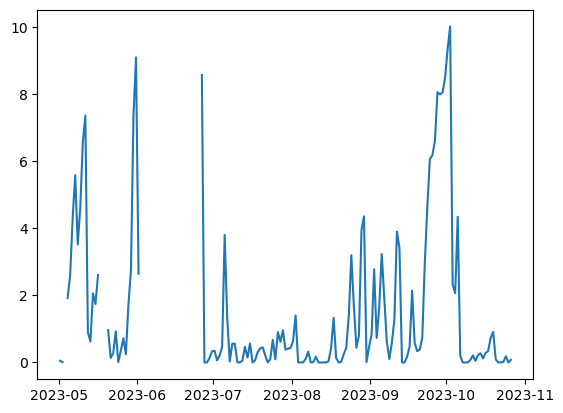

In [182]:
fire_tmp = test

fire_id = fire_tmp[fire_tmp.fireID == '8553']
fire_id.t = fire_id.t.astype('datetime64[ns]')
fire_id = fire_id.sort_values(by = ["fireID", "t"])
plt.plot(fire_id.t, fire_id.FWI)
print(min(fire_id.t))
print(max(fire_id.t))

In [223]:
#fire_tmp.loc[~fire_tmp.t.str.contains("."), ["t"]] = fire_tmp.t[~fire_tmp.t.str.contains("."), ["t"]] + ".000"

#fire_tmp.t[~fire_tmp.t.str.contains(".")] = fire_tmp.t[~fire_tmp.t.str.contains(".")] + ".000"
#fire_tmp.t[fire_tmp.t ==  "2023-11-27 12:00:00"] = "2023-11-27 12:00:00" + ".000"
#fire_tmp[fire_tmp.t.str.contains("12:00:00") & (~fire_tmp.t.str.contains(".000"))].t = fire_tmp[fire_tmp.t.str.contains("12:00:00") & (~fire_tmp.t.str.contains(".000"))].t.astype('str') + '.000'

fire_tmp["pretty_date_format"] = fire_tmp.t.astype("datetime64[ns]").dt.strftime("%m-%d %p")
#no_dupes2 = fire_tmp[["fireID", "pretty_date_format", "FWI", "lat_centroid", "t"]]
#no_dupes2 = no_dupes2.dropna()
#no_dupes2 = no_dupes2.drop_duplicates(subset = ["fireID", "t"])
no_dupes2 = fire_tmp[["fireID", "pretty_date_format", "FWI", "lat_centroid", "t"]]
no_dupes2 = no_dupes2.dropna()
#no_dupes2 = no_dupes2.drop_duplicates(subset = ["lat_centroid", "pretty_date_format"])
no_dupes2 = no_dupes2.drop_duplicates(subset = ["fireID", "t"])

05-03 PM
10-15 PM


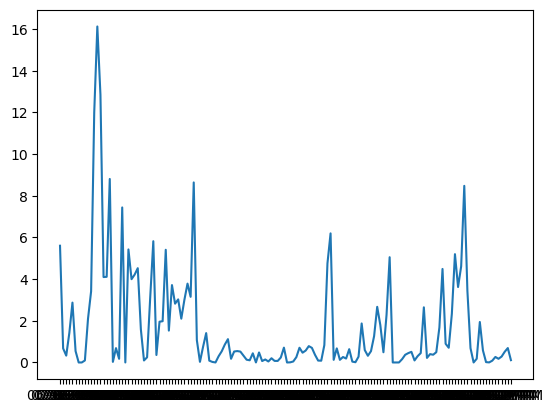

In [224]:
#no_dupes2.lat_centroid[0]
#no_dupes2[no_dupes2.lat_centroid == 52.516399]
no_dupes2[no_dupes2.lat_centroid == 52.516399219991065].FWI.unique()
plt.plot(no_dupes2[no_dupes2.lat_centroid == 52.516399219991065].pretty_date_format, no_dupes2[no_dupes2.lat_centroid == 52.516399219991065].FWI)
print(min(no_dupes2[no_dupes2.lat_centroid == 52.516399219991065].pretty_date_format))
print(max(no_dupes2[no_dupes2.lat_centroid == 52.516399219991065].pretty_date_format))

In [225]:
lats2 = no_dupes2.groupby("fireID").lat_centroid.mean().reset_index()


from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

no_dupes2 = no_dupes2[['fireID', 'pretty_date_format', "FWI", 't']].merge(lats2, on = ["fireID"])

#heat = no_dupes.pivot(index =["fireID", "lat_centroid"],  columns=["pretty_date_format"], values="farea_diff")
heat2 = no_dupes2.pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values="FWI")

heat2 = heat2.sort_values(by = "lat_centroid", ascending= False)

heat2.index = heat2.index.astype("float64")
heat2.index = heat2.index.values.round(2)

In [62]:
#len(heat2.index.values.astype("float64"))

In [ ]:
#fire2[["fireID", "pretty_date_format", "FWI", "lat_centroid", "t"]].dropna()

Text(55.847222222222214, 0.5, 'FWI')

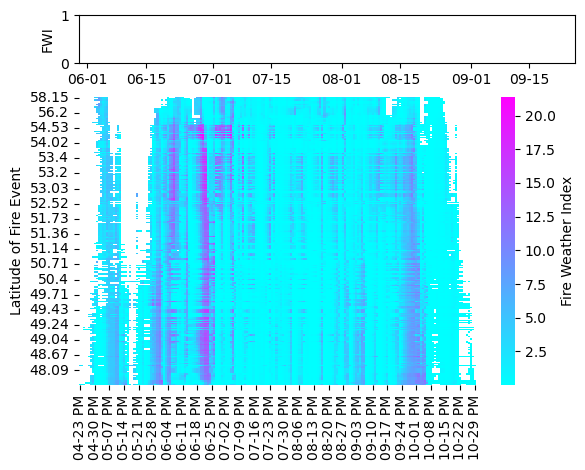

In [226]:
import matplotlib.dates as mdates
import seaborn as sn

fig, (ax, ax2) = plt.subplots(2, gridspec_kw={'height_ratios': [1, 6]})
#fig.suptitle('Aligning x-axis using sharex')
ax2 = sn.heatmap(heat2, cmap = "cool", cbar_kws={'label': 'Fire Weather Index'}, fmt='.1f')#, 
               #yticklabels=heat.index.values.round(0))
ax2.set(xlabel="", ylabel="Latitude of Fire Event")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
ax.set_ylabel("FWI")


In [217]:
#heat2.index[(heat2.index > 52.52) & (heat2.index < 53.03)] #53.01, 52.95, 52.95, 52.92 ,52.9, 52.9

heat2[heat2.index == 52.92].dropna(axis = 1)

pretty_date_format,05-04 PM,05-05 PM,05-06 PM,05-07 PM,05-08 PM,05-10 PM,05-11 PM,05-12 PM,05-20 PM,05-26 PM,...,10-11 PM,10-12 PM,10-13 PM,10-14 PM,10-15 PM,10-16 PM,10-17 PM,10-18 PM,10-19 PM,10-20 PM
52.92,4.527971,2.432858,5.567594,4.432668,3.615537,1.933514,1.984542,2.881426,7.953141,1.398279,...,0.465732,0.366866,0.362085,0.626823,1.825272,0.746424,0.506284,2.139402,0.076031,0.419676


In [221]:
no_dupes2[(no_dupes2.lat_centroid > 52.90) & (no_dupes2.lat_centroid < 52.95)]

,pretty_date_format,FWI,lat_centroid
58289,08-03 PM,1.742744,52.924719
58291,08-04 PM,2.337015,52.924719
58299,08-07 PM,7.226785,52.924719
58425,05-04 PM,4.527971,52.924719
58426,05-05 PM,2.432858,52.924719
...,...,...,...
69578,10-12 PM,0.160359,52.946850
69579,10-13 PM,0.381093,52.946850
69580,10-14 PM,0.710394,52.946850
69581,10-15 PM,1.635434,52.946850


In [ ]:
### Check differences in the two "fire" objects

fires[fires.farea == fires.farea.max()].fireID.unique()

In [65]:
#fire2[fire2.farea == fire2.farea.max()].fireID.unique()

In [66]:
#fire2[fire2.fireID == "8495"] ## That ID is missing, WHY? Merged into new? Butthe fire2 fire is smaller. 

In [67]:
fires[fires.farea == fires.farea.max()].farea.unique()

array([12249])

In [68]:
fire3[fire3.farea == fire3.farea.max()].fireID.unique()

array(['8495'], dtype=object)

In [ ]:
print("IDS in fires but not in fire3", fires[~fires.fireID.isin(fire3.fireID)].fireID.unique())
print("______________________")
print("IDS in fire3 but not in fires", fire3[~fire3.fireID.isin(fires.fireID)].fireID.unique())
print("______________________")
print("IDS in fires but not in fire2", fires[~fires.fireID.isin(fire2.fireID)].fireID.unique())
print("______________________")
print("IDS in fire2 but not in fire3", fire2[~fire2.fireID.isin(fire3.fireID)].fireID.unique())
print("______________________")
print("IDS in fire3 but not in fire2", fire3[~fire3.fireID.isin(fire2.fireID)].fireID.unique())



In [69]:
## Check if any of the fire objects have the same IDS as the IDS fed into the for loop

def lf_ids(year = None, regnm = 'BOREAL_NRT_3571_DPS'):
    
    diroutdata = "s3://maap-ops-workspace/shared/gsfc_landslides/FEDSoutput-s3-conus/"

    if year == None:
        year = date.today().year

    if diroutdata.startswith("s3://"):
        # Can't use glob for S3. Use s3.ls instead.
        s3 = s3fs.S3FileSystem(anon=False)
        s3path = os.path.join(diroutdata, regnm, str(year), "Largefire")
        fnms = [f for f in s3.ls(s3path)]


    fnms.sort()
    ids = []
    for f in fnms:
        fnm_lts = os.path.basename(f) 
        one_id = fnm_lts[1:-11]
        ids.append(one_id)
    tmp_ids = pd.DataFrame(ids, columns=["ids"])
    tmp_ids = tmp_ids.ids.unique()
    return(tmp_ids)

def unique(list1):
 
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    return(unique_list)

def get_listed_ids(quebec_stats):
    newlist = [x.strip('][\n').split(' ') for x in quebec_stats.fireID.unique()]
    newlist = list(chain(*newlist))
    newlist = [x.replace('\n', ' ') for x in newlist]
    newlist = unique(newlist)
    return(newlist)

def concat_subsets(files):
    df = []
    for f in files:
        #manyfr = pd.read_csv(f, parse_dates=['t'], date_parser=dateparse)
        manyfr = pd.read_csv(f)
        manyfr = gpd.GeoDataFrame(manyfr)
        
        
        manyfr.t[~manyfr.t.str.contains("12:00:00")] = manyfr.t[~manyfr.t.str.contains("12:00:00")] + " 00:00:00"
        #print(manyfr.t[~manyfr.t.str.contains("12:00:00")])
        
        manyfr.t = manyfr.t.astype("datetime64[ns]")
        #manyfr.t = manyfr.t.astype("str")

        
        #manyfr.t.tz("UCT")
        df.append(manyfr)
    df = pd.concat(df)
    #df.t = df.t.astype("datetime64[ns]")
    return(df)


In [ ]:
files = glob.glob("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats//boreal_snapstats*.csv")


fire_stats = concat_subsets(files)

fire_stats.t.max()

### Subsetting fire stats by largefire record, so don't waste time looking for IDs that we haven't got yet. Wait, not worth it, size a bigger thing anyway.
#fire_stats = fire_stats[fire_stats.t < "2023-07-20 12:00:00"]

#fire_stats = pd.read_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats/boreal_snapstats_20231024.csv")

quebec_stats = fire_stats[fire_stats.prov_name_en == "Quebec"]

tmp_list = get_listed_ids(quebec_stats)

ids_lf = lf_ids( year = "2023")

tmp_list = list(set(tmp_list).intersection(ids_lf))

In [91]:
print("IDS in fires but not in tmp_list", fires[~fires.fireID.isin(tmp_list)].fireID.unique())
print("______________________")
print("IDS in fire3 but not in tmp_list", fire3[~fire3.fireID.isin(tmp_list)].fireID.unique())
print("______________________")
print("IDS in fire2 but not in tmp_list", fire2[~fire2.fireID.isin(tmp_list)].fireID.unique())
print("______________________")




IDS in fires but not in tmp_list []
______________________
IDS in fire3 but not in tmp_list []
______________________
IDS in fire2 but not in tmp_list []
______________________


In [88]:
set(tmp_list).symmetric_difference(fire3.fireID.unique())

{'10546',
 '12146',
 '16038',
 '16045',
 '16046',
 '16049',
 '16062',
 '16065',
 '16109',
 '16112',
 '16113',
 '16141',
 '16143',
 '16227',
 '16321',
 '16417',
 '16433',
 '16441',
 '16447',
 '16456',
 '16457',
 '16459',
 '16519',
 '16520',
 '16528',
 '16644',
 '16730',
 '16963',
 '17368',
 '17369',
 '17644',
 '8553'}

In [89]:
set([1,2,3,4]).symmetric_difference([1,2])

{3, 4}

In [90]:
set([1,2]).symmetric_difference([1,2,3,4])

{3, 4}

In [92]:
fire3[fire3.fireID == '8553']

,fireID,t,geometry,Unnamed: 0,InterCloud,lat,lon,current_mag,error_elps,num_station,...,FWI_lead_2,FWI_lead_3,FWI_lead_4,FWI_lead_5,FWI_lead_6,FWI_lead_7,FWI_lead_8,pre_fire,farea_diff,pretty_date_format


In [93]:
len(fire3.fireID.unique())

215